<a href="https://colab.research.google.com/github/XinXu-ease/XAI-assignment3-9.21/blob/main/9_20_XAI_Assignment_Xin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [2]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")

Prediction for Patient X: Benign → No Biopsy


# SHAP

In [3]:
# !pip install shap -q  # uncomment if SHAP isn't installed
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
assert isinstance(X_train, pd.DataFrame), "X_train should be a pandas DataFrame."
assert isinstance(focus_instance_bc, pd.DataFrame) and len(focus_instance_bc)==1, "sample must be a 1-row DataFrame."

In [5]:
# 1) Build a SHAP explainer
# Use a small, representative background to speed things up
bg = shap.utils.sample(X_train, 200, random_state=42) if len(X_train) > 200 else X_train.copy()
# Generic constructor picks the right algorithm (TreeExplainer, Linear, or Kernel) under the hood
try:
    explainer = shap.Explainer(model_bc, bg)
except Exception as e:
    # Fallback to model-agnostic if automatic selection fails
    explainer = shap.KernelExplainer(
        # For classification prefer the probability of the positive class if available
        (lambda X: model_bc.predict_proba(X)[:, 1]) if hasattr(model_bc, "predict_proba") else model_bc.predict,
        shap.kmeans(bg, k=min(50, len(bg)))  # smaller background for KernelExplainer
    )


In [6]:
#2) Explain THE instance
# SHAP expects the same structure the model sees
shap_values_sample = explainer(focus_instance_bc)

# If KernelExplainer was used and returned ndarray, wrap to Explanation for newer plots
if not isinstance(shap_values_sample, shap._explanation.Explanation):
    shap_values_sample = shap.Explanation(
        values=shap_values_sample,
        base_values=np.atleast_1d(explainer.expected_value if np.ndim(explainer.expected_value)==0
                                  else np.array(explainer.expected_value)).squeeze(),
        data=focus_instance_bc.values,
        feature_names=list(focus_instance_bc.columns)
    )

In [7]:
print("values shape:", np.shape(shap_values_sample.values))
print("base_values shape:", np.shape(shap_values_sample.base_values))

values shape: (1, 30, 2)
base_values shape: (1, 2)


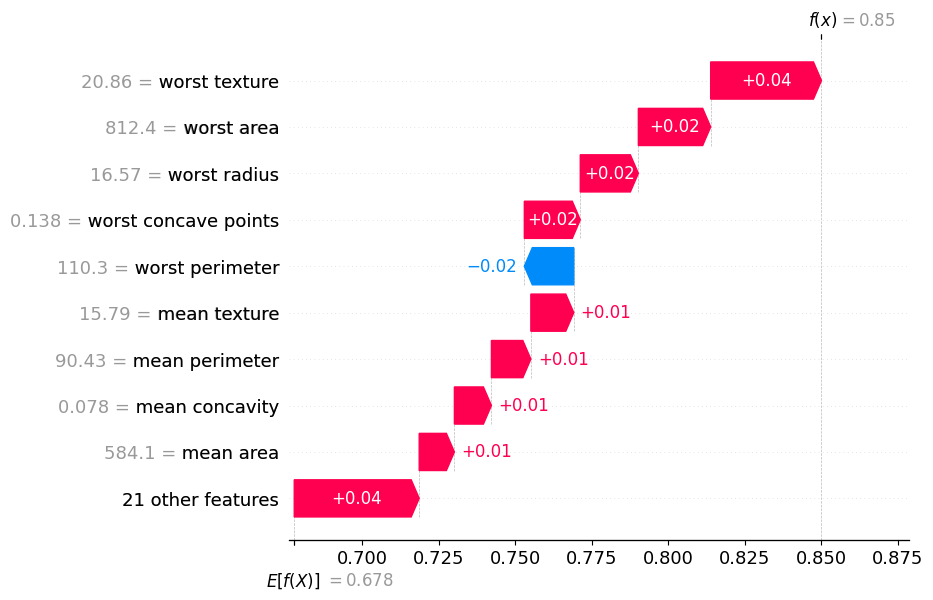

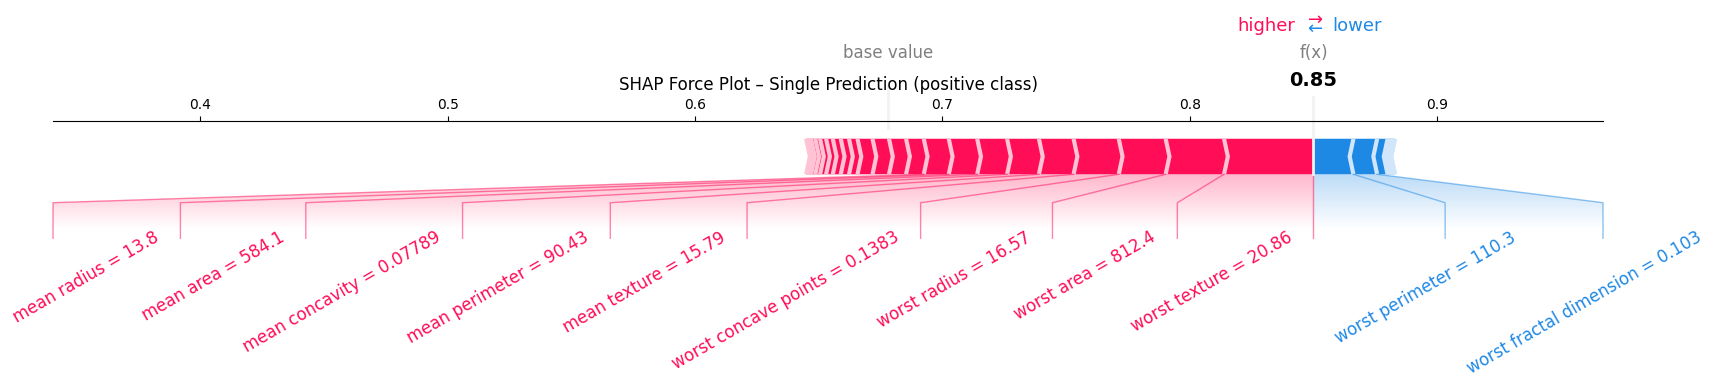

In [8]:
# Choose which class to visualize (positive class)
POS = 1 # cho benign as positive class

def to_single_output(expl: shap.Explanation, class_index: int = POS) -> shap.Explanation:
    """
    Convert a multi-output SHAP Explanation (values: [n, f, c], base: [n, c])
    into a single-output Explanation (values: [n, f], base: [n]).
    """
    vals = expl.values
    base = expl.base_values
    # If already single-output, return as-is
    if np.ndim(vals) == 2:
        return expl
    # Otherwise slice the desired class
    vals_single = vals[:, :, class_index]        # (n_samples, n_features)
    base_single = base[:, class_index]           # (n_samples,)
    return shap.Explanation(
        values=vals_single,
        base_values=base_single,
        data=expl.data,
        feature_names=expl.feature_names
    )

# 1) Explain your single row
# You already have: explainer, sample (1-row DataFrame)
shap_multi = explainer(focus_instance_bc)               # (1, n_features, 2) values; (1, 2) base_values
sv = to_single_output(shap_multi, POS)       # now (1, n_features) and (1,)

# Waterfall (single prediction)
plt.figure()
shap.plots.waterfall(sv[0], show=True)

# Force plot (single prediction) — static matplotlib version
shap.plots.force(sv[0], text_rotation=30, matplotlib=True, show=False)
plt.title("SHAP Force Plot – Single Prediction (positive class)")
plt.tight_layout
plt.savefig("shap_force_single_positive.png", dpi=200)
plt.show()




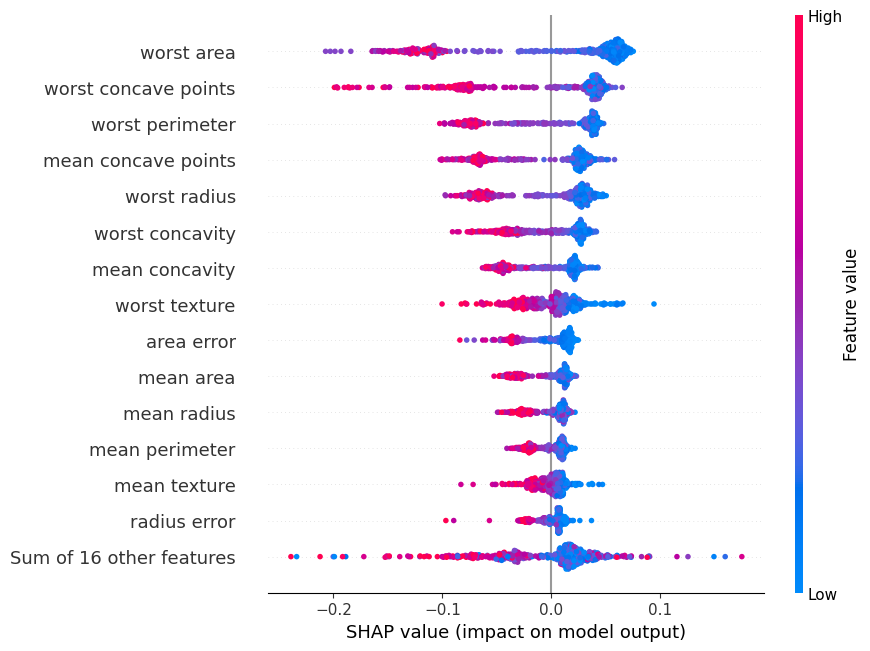

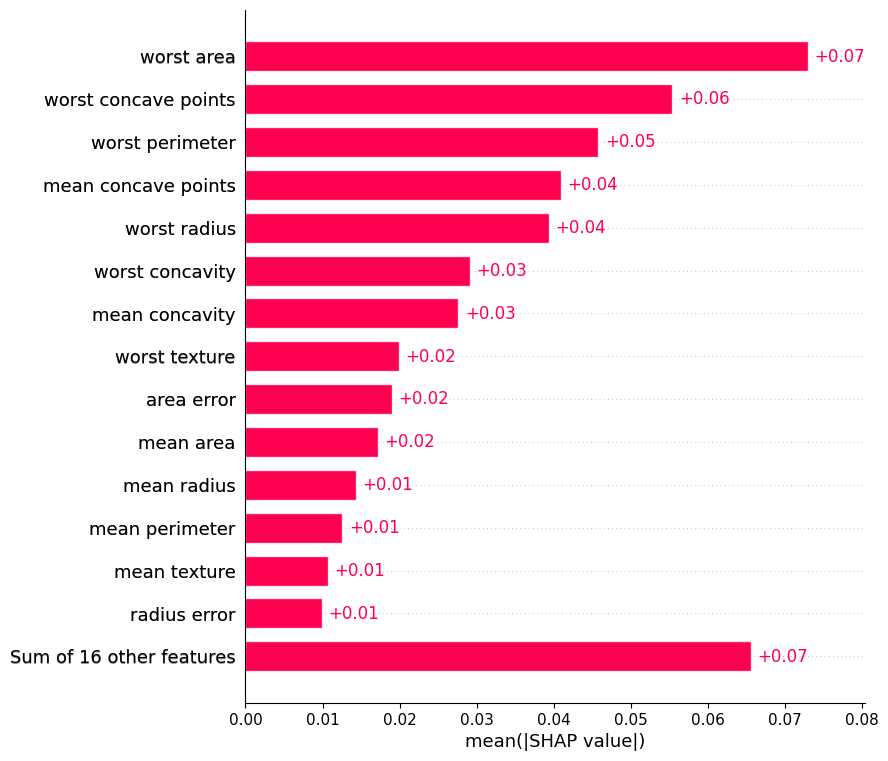

Baseline (expected value): 0.6779000000000002
Sum of SHAP values: 0.1720999985512754
Model output (on SHAP's additive scale): 0.8499999985512756

Top contributing features:


,feature,value,shap_value
21,worst texture,20.86000,0.036161
23,worst area,812.40000,0.023607
20,worst radius,16.57000,0.018962
27,worst concave points,0.13830,0.018259
22,worst perimeter,110.30000,-0.016141
1,mean texture,15.79000,0.014012
2,mean perimeter,90.43000,0.012874
6,mean concavity,0.07789,0.012087
3,mean area,584.10000,0.011488
0,mean radius,13.80000,0.010108


In [9]:
# 2) Global context (eval slice)
# You already have X_train; use a small slice for speed
X_eval = shap.utils.sample(X_train, 1000, random_state=0) if len(X_train) > 1000 else X_train.copy()
shap_multi_eval = explainer(X_eval)          # (m, n_features, 2), (m, 2)
sv_eval = to_single_output(shap_multi_eval, POS)

# Beeswarm & bar (global importance for the chosen class)
plt.figure()
shap.plots.beeswarm(sv_eval, max_display=15, show=True)

plt.figure()
shap.plots.bar(sv_eval, max_display=15, show=True)

# 3) Tidy table of top contributors
sv_row = sv.values[0]                        # (n_features,)
base = np.ravel(sv.base_values)[0]           # scalar
contrib_df = (
    pd.DataFrame({
        "feature": sv.feature_names,
        "value": focus_instance_bc.iloc[0].values,
        "shap_value": sv_row
    })
    .sort_values("shap_value", key=np.abs, ascending=False)
)
print("Baseline (expected value):", base)
print("Sum of SHAP values:", sv_row.sum())
print("Model output (on SHAP's additive scale):", base + sv_row.sum())
print("\nTop contributing features:")
display(contrib_df.head(15))

**Citation:**

The code for SHAP interpretion is assisted by ChatGPT, here is the conversation link：https://chatgpt.com/share/68cdc3a1-a24c-8008-9a9e-7de04af67ea2 Generated on 09.19.2025 at 17:00.

**Thinking:**

The SHAP model, interpreting both individual predictions and global samples, yielded similar results: worst area, worst concave points, worst perimeter, and worst radius were all among the top 5 influencing factors. However, in this case, worst area was the most important, with mean concave points also among the top 5. Overall, worst texture was the most critial factor. Subjectively, this experience with cancer diagnosis suggests that worst texture is the most decisive feature for determining a patient's diagnosis. However, this sample patient's case was unique; perhaps her worst texture symptoms were less typical, while her area findings were highly typical, making area the "decisive" factor in determining the diagnosis.

# LIME

In [10]:
# LIME for a single prediction (tabular data)

!pip install lime
from lime.lime_tabular import LimeTabularExplainer
import numbers
import os

# Helper: build functions to coerce inputs nicely
def _to_numpy(X):
    if isinstance(X, pd.DataFrame):
        return X.values
    elif isinstance(X, np.ndarray):
        return X
    else:
        raise TypeError("X must be a pandas DataFrame or a numpy array")

def _get_feature_names(X):
    if isinstance(X, pd.DataFrame):
        return list(X.columns)
    else:
        return [f"f{i}" for i in range(X.shape[1])]

def _get_categorical_indices(X):
    if isinstance(X, pd.DataFrame):
        return [i for i, dt in enumerate(X.dtypes) if str(dt) in ("object", "category", "bool")]
    return None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5e843f73b1006f788b98940f13d9fd5f547df313731598b4e3e6189fe5d16de4
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [11]:
# Detect task type (classification if predict_proba is available)

is_classifier = hasattr(model_bc, "predict_proba")

# Prepare arrays, feature names, categories
X_train_np = _to_numpy(X_train)
feature_names = _get_feature_names(X_train)
categorical_idx = _get_categorical_indices(X_train)


In [12]:
# Coerce the sample to 1D numpy
# Access the first row of the DataFrame and get its values as a numpy array
x_sample = focus_instance_bc.values[0]

if isinstance(x_sample, pd.Series):
    x0 = x_sample.values
elif isinstance(x_sample, (pd.DataFrame, np.ndarray)) and np.ndim(x_sample) == 2:
    # If a single-row DataFrame/2D array was given
    if x_sample.shape[0] == 1:
        x0 = x_sample.reshape(-1)
    else:
        raise ValueError("x_sample has multiple rows; pass just one instance to explain.")
elif isinstance(x_sample, np.ndarray) and x_sample.ndim == 1:
    x0 = x_sample
else:
    raise TypeError("x_sample should be a pandas Series, a single-row DataFrame, or a 1D numpy array")

In [13]:
# Class names (optional but nicer for plots)
# -----------------------------------------
class_names = None
if is_classifier:
    if "class_names" in globals() and class_names is not None:
        pass
    elif isinstance(y_train, (pd.Series, np.ndarray)):
        # Try to infer sorted unique labels
        uniq = pd.Series(y_train).unique()
        # If labels look like {0,1}, map to strings
        if len(uniq) <= 10:
            # sort by value if numeric, else by string
            try:
                uniq_sorted = sorted(uniq, key=lambda x: (isinstance(x, numbers.Number), x))
            except Exception:
                uniq_sorted = list(uniq)
            class_names = [str(u) for u in uniq_sorted]
        else:
            class_names = None


In [14]:
# Explain the instance

num_features = min(10, len(feature_names))

explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    categorical_features=categorical_idx,
    mode='classification'
)

if is_classifier:
    # Explain w.r.t. the predicted label (top_labels=1 picks the model’s top class)
    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=model_bc.predict_proba,
        num_features=num_features,
        top_labels=1
    )
    # Use the top label that the model predicted
    label = exp.available_labels()[0]
else:
    # Regression uses model.predict
    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=model_bc.predict,
        num_features=num_features
    )
    label = None  # not used for regression

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

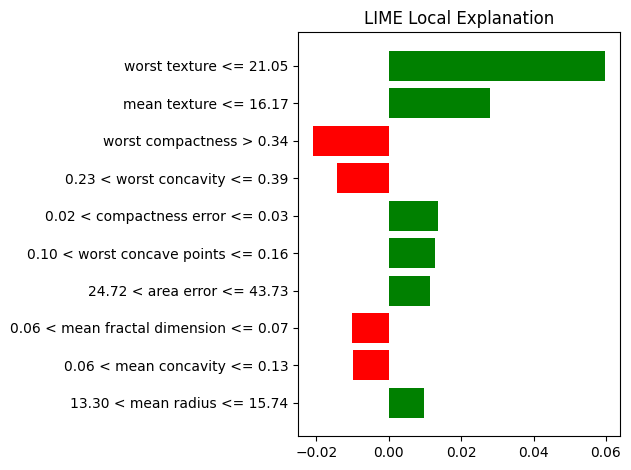

In [15]:
# 1) Native LIME plot
plt.figure()
fig = exp.as_pyplot_figure(label=label) if is_classifier else exp.as_pyplot_figure()
plt.title("LIME Local Explanation")
plt.tight_layout()
plt.show()

**Citation**

The code for SHAP interpretion is assisted by ChatGPT, here is the conversation link：https://chatgpt.com/share/68cee1fe-688c-8008-acd0-5a9d400a104a Generated on 09.19.2025 at 17:00.

**Thinking:**

In LIME's interpretion, the "cause" isn't about individual features, but rather the condition of a feature. The most important conditions are: worst texture <= 21.05, mean texture <= 16.17, worst compactness > 0.34, 0.23 < worst concavity <= 0.39, and 24.72 < area error <= 43.73. Two of these conditions are negatively correlated. lime automatically partitions feature data into intervals and provides coefficients (weignt) to determine the local model to explain the factors driving the prediction. It lacks a global interpretation, so it may be affected by sampling randomness.

**Comparison:**

The two models produce different results. In LIME's interpretation, worst texture is a key factor, similar to SHAP's global interpretation. Beyond that, they differ. This is due to differences in their theoretical approach and feature processing. LIME uses neighboring points and binning for sampling, while SHAP uses Shapley value theory, which uses unique values.